**Sprawozdanie z lab9**
*Piotr Piotrak, 82667*

In [ ]:
!nvcc --version
!pip install git+https://github.com/andreinechaev/nvcc4jupyter.git
%load_ext nvcc_plugin

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2021 NVIDIA Corporation
Built on Sun_Feb_14_21:12:58_PST_2021
Cuda compilation tools, release 11.2, V11.2.152
Build cuda_11.2.r11.2/compiler.29618528_0
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/andreinechaev/nvcc4jupyter.git to /tmp/pip-req-build-obf3nl90
  Running command git clone --filter=blob:none --quiet https://github.com/andreinechaev/nvcc4jupyter.git /tmp/pip-req-build-obf3nl90
  Resolved https://github.com/andreinechaev/nvcc4jupyter.git to commit aac710a35f52bb78ab34d2e52517237941399eff
  Preparing metadata (setup.py) ... done
  Created wheel for NVCCPlugin: filename=NVCCPlugin-0.0.2-py3-none-any.whl size=4304 sha256=fba78d60373247aa0f64976927788543146dfd86351679100a08308994bd2b0e
  Stored in directory: /tmp/pip-ephem-wheel-cache-6mej8eol/wheels/f3/08/cc/e2b5b0e1c92df07dbb50a6f024a68ce090f5e7b2316b41756d
Successfully built NVCCPlugin
cr

Wersja na GPU:

In [ ]:
%%cu
#include <stdio.h>

#define DIM 2048

#define rnd(x) (x* rand() / RAND_MAX)
#define INF 2e10f

struct Sphere {
  float r,b,g;
  float radius;
  float x,y,z;
  __device__ float hit(float ox, float oy, float *n) {
    float dx = ox - x;
    float dy = oy - y;
    if (dx*dx + dy*dy < radius*radius) {
      float dz = sqrtf(radius*radius - dx*dx - dy*dy);
      *n = dz / sqrtf(radius * radius);
      return dz + z;
    }
    return -INF;
  }
};

#define SPHERES 20

__global__ void kernel(Sphere *s, unsigned char *ptr) {
  // map from threadIdx/BlockIdx to pixel position
  int x = threadIdx.x + blockIdx.x * blockDim.x;
  int y = threadIdx.y + blockIdx.y * blockDim.y;
  int offset = x + y * blockDim.x * gridDim.x;
  float ox = (x - DIM/2);
  float oy = (y - DIM/2);

  float r=0, g=0, b=0;
  float maxz = -INF;
  for(int i=0;i<SPHERES;i++) {
    float n;
    float t = s[i].hit(ox,oy,&n);
    if (t > maxz) {
      float fscale = n;
      r = s[i].r * fscale;
      g = s[i].g * fscale;
      b = s[i].b * fscale;
      maxz = t;
    }
  }
  ptr[offset*4 + 0] = (int)(r * 255);
  ptr[offset*4 + 1] = (int)(g * 255);
  ptr[offset*4 + 2] = (int)(b * 255);
  ptr[offset*4 + 3] = 255;
}

struct DataBlock {
  unsigned char *dev_bitmap;
};

void save_to_file(unsigned char *ptr){
    FILE *fp = fopen("Fraktal_GPU_RayTracing.txt", "w");
    for(int y=0;y<DIM;y++){
        for(int x=0;x<DIM;x++) {
            int offset = x + y * DIM;
            fprintf(fp, "%d %d %d", ptr[offset * 4 + 0], ptr[offset * 4 + 1], ptr[offset * 4 + 2], ptr[offset * 4 + 3]);
        }
    } 
    fclose(fp);
}

int main(void){
    cudaEvent_t start, stop;
    cudaEventCreate(&start);
    cudaEventCreate(&stop);
    cudaEventRecord(start, 0);
    
    DataBlock data;
    unsigned char *bitmap = (unsigned char*)malloc(DIM*DIM*4*sizeof (unsigned char));
    int image_size = DIM*DIM*4*sizeof (unsigned char);
    unsigned char *dev_bitmap;
    cudaMalloc((void**)&dev_bitmap, image_size);
    data.dev_bitmap = dev_bitmap;
    Sphere *s;
    cudaMalloc((void**)&s, sizeof(Sphere)*SPHERES);
    Sphere *temp_s = (Sphere*)malloc(sizeof(Sphere)*SPHERES);
    for(int i=0;i<SPHERES;i++) {
      temp_s[i].r = rnd(1.0f);
      temp_s[i].g = rnd(1.0f);
      temp_s[i].b = rnd(1.0f);
      temp_s[i].x = rnd(1000.0f) - 500;
      temp_s[i].y = rnd(1000.0f) - 500;
      temp_s[i].z = rnd(1000.0f) - 500;
      temp_s[i].radius = rnd(100.0f) + 20;
    }
    cudaMemcpy(s, temp_s, sizeof(Sphere)*SPHERES, cudaMemcpyHostToDevice);
    free(temp_s);
    save_to_file(bitmap);

    cudaEventRecord(stop, 0);
    cudaEventSynchronize(stop);

    float elapsedTime;
    cudaEventElapsedTime(&elapsedTime, start, stop);
    printf("Czas wykonywania: %f s\n", elapsedTime/1000);

    return 0;
}

Czas wykonywania: 0.623774 s



Ray tracing to metoda generowania obrazów trójwymiarowych, polegająca na symulowaniu promieni światła wchodzących do sceny i ich interakcji z jej elementami.

Kod składa się z kilku głównych części:

*   definicja struktury Sphere, reprezentującej kulę w scenie, zawierającej informacje o jej kolorze, położeniu i promieniu
*   deklaracja funkcji kernel, która jest wykonywana na GPU i odpowiada za obliczanie koloru dla każdego piksela na ekranie
*   deklaracja funkcji save_to_file, która zapisuje wynikowy obraz do pliku tekstowego
*   funkcja main, gdzie inicjalizowane są dane potrzebne do wykonania ray tracingu oraz wywoływana jest funkcja kernel na GPU.

Funkcja kernel jest uruchamiana dla każdego piksela na ekranie i działa w następujący sposób:

*   dla każdej kuli w scenie obliczany jest moment trafienia promienia w nią oraz wektor normalny do powierzchni kuli
*   dla każdego piksela wybierana jest kula, dla której moment trafienia jest największy, a kolor piksela ustawiany jest na kolor tej kuli
*   obliczony kolor piksela jest zapisywany do tablicy bitmap

Funkcja save_to_file zapisuje obraz do pliku tekstowego, gdzie każdy piksel jest zapisywany w formacie RGB.
W funkcji main zostają zainicjalizowane dane potrzebne do wykonania ray tracingu, takie jak tablica bitmap, tablica kul oraz alokowana pamięć na GPU. Następnie zostaje wywołana funkcja kernel i zapisany plik z wynikowym obrazem.
Na końcu zostaje wyświetlony czas wykonania programu.

Wersja na CPU:

In [ ]:
%%cu
#include <stdio.h>
#include <stdlib.h>
#include <math.h>
#include <time.h>

#define DIM 2048

#define rnd(x) (x* rand() / RAND_MAX)
#define INF 2e10f

struct Sphere {
  float r,b,g;
  float radius;
  float x,y,z;
  float hit(float ox, float oy, float *n) {
    float dx = ox - x;
    float dy = oy - y;
    if (dx*dx + dy*dy < radius*radius) {
      float dz = sqrtf(radius*radius - dx*dx - dy*dy);
      *n = dz / sqrtf(radius * radius);
      return dz + z;
    }
    return -INF;
  }
};

#define SPHERES 20

void render(Sphere *s, unsigned char *ptr) {
  for (int x = 0; x < DIM; x++) {
    for (int y = 0; y < DIM; y++) {
      float ox = (x - DIM/2);
      float oy = (y - DIM/2);

      float r=0, g=0, b=0;
      float maxz = -INF;
      for(int i=0;i<SPHERES;i++) {
        float n;
        float t = s[i].hit(ox,oy,&n);
        if (t > maxz) {
          float fscale = n;
          r = s[i].r * fscale;
          g = s[i].g * fscale;
          b = s[i].b * fscale;
          maxz = t;
        }
      }
      int offset = x + y * DIM;
      ptr[offset*4 + 0] = (int)(r * 255);
      ptr[offset*4 + 1] = (int)(g * 255);
      ptr[offset*4 + 2] = (int)(b * 255);
      ptr[offset*4 + 3] = 255;
    }
  }
}

void save_to_file(unsigned char *ptr){
    FILE *fp = fopen("Fraktal_CPU_RayTracing.txt", "w");
    for(int y=0;y<DIM;y++){
        for(int x=0;x<DIM;x++) {
            int offset = x + y * DIM;
            fprintf(fp, "%d %d %d", ptr[offset * 4 + 0], ptr[offset * 4 + 1], ptr[offset * 4 + 2], ptr[offset * 4 + 3]);
        }
    } 
    fclose(fp);
}

int main(void){
    clock_t start_time = clock();

    Sphere *s = (Sphere*)malloc(sizeof(Sphere)*SPHERES);
    for(int i=0;i<SPHERES;i++) {
      s[i].r = rnd(1.0f);
      s[i].g = rnd(1.0f);
      s[i].b = rnd(1.0f);
      s[i].x = rnd(1000.0f) - 500;
      s[i].y = rnd(1000.0f) - 500;
      s[i].z = rnd(1000.0f) - 500;
      s[i].radius = rnd(50.0f);
    }
    unsigned char *bitmap = (unsigned char*)malloc(DIM*DIM*4*sizeof (unsigned char));
    render(s, bitmap);
    save_to_file(bitmap);
    free(bitmap);
    free(s);

    clock_t end_time = clock();
    printf("Czas wykonywania: %f s\n", (double)(end_time - start_time)/CLOCKS_PER_SEC);
    return 0;
}

Czas wykonywania: 1.423819 s



Kod tworzy losowe kule (struktura Sphere) i umieszcza je w losowych pozycjach. Następnie dla każdego pixela na ekranie generowany jest promień, który jest testowany na przecięcie z każdą z kul. Jeśli promień przecina kulę, obliczana jest odległość od kamery oraz kolor kuli na podstawie odległości. Kolor z kuli z największą odległością jest używany jako kolor pixela.

Wynikowy obraz jest zapisywany do pliku tekstowego "Fraktal_CPU_RayTracing.txt" i czas wykonania programu jest wyświetlany na konsoli.

## **Wykresy:**

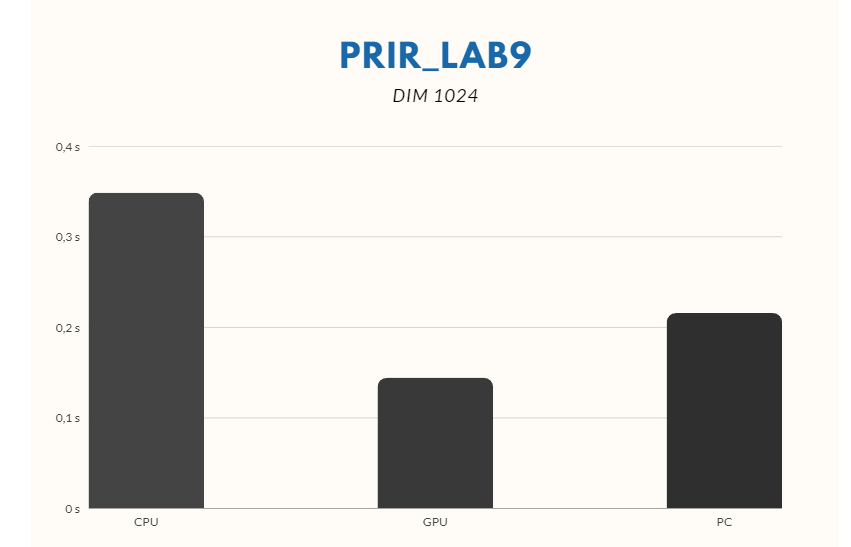

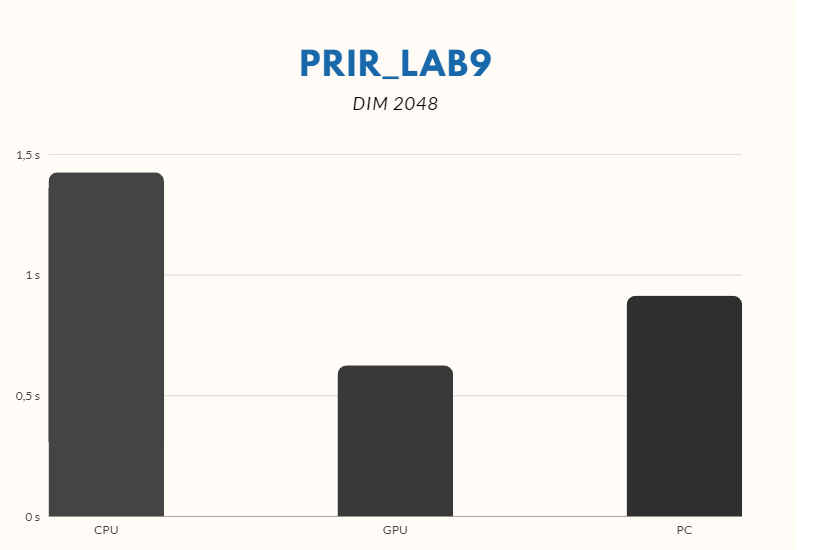